In [1]:
import numpy as np
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

In [2]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [150]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)
print(coreg_in_silico.shape)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})
print(prf_df.shape)
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
workshop2file = 'all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])




(12094, 23)
(1051, 10)


In [154]:
print(prf_df.shape)

(1051, 10)


In [157]:
len(np.unique(prf_df[['pt_root_id']]))

1051

In [151]:
coreg_in_silico.shape

(12094, 23)

In [147]:
prf_df.shape

(1051, 10)

In [149]:
coreg_df.shape

(13925, 19)

In [153]:
len(np.unique(coreg_df[['target_id']]))

12054

In [152]:
clean_coreg_df.shape

(583, 32)

In [140]:
clean_coreg_df.columns

Index(['id_x', 'created_x', 'superceded_id', 'valid_x', 'valid_id',
       'status_dendrite', 'status_axon', 'pt_supervoxel_id_x', 'pt_root_id',
       'pt_position_x', 'id_ref', 'created_ref', 'valid_ref', 'volume',
       'pt_supervoxel_id_y', 'id_y', 'created_y', 'valid_y', 'target_id',
       'session', 'scan_idx', 'unit_id', 'field', 'residual', 'score',
       'pt_position_y', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [141]:
len(np.unique(clean_coreg_df[['unit_id']]))

649

In [4]:
all_syn_dfm3.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id', 'pre_pt_position', 'post_pt_position', 'index_pre',
       'scan_session_pre', 'scan_idx_pre', 'field_pre', 'unit_id_pre',
       'score_pre', 'residual_pre', 'index_post', 'scan_session_post',
       'scan_idx_post', 'field_post', 'unit_id_post', 'score_post',
       'residual_post', 'C', 'cell_type_pre', 'cell_type_post'],
      dtype='object')

In [125]:
np.unique(all_syn_dfm3[['cell_type_pre']])

array(['L2a', 'L2b', 'L3a', 'L3b', 'L3c', 'L4a', 'L4b', 'L4c', 'L5ET',
       'L5NP', 'L5a', 'L5b', 'L6a'], dtype=object)

In [124]:
np.unique(all_syn_dfm3[['cell_type_post']])

array(['L2a', 'L2b', 'L3a', 'L3b', 'L3c', 'L4a', 'L4b', 'L4c', 'L5ET',
       'L5NP', 'L5a', 'L5b', 'L6CT', 'L6a', 'L6b'], dtype=object)

In [129]:
sub = all_syn_dfm3[all_syn_dfm3['cell_type_post'] == 'L6b']
len(sub)

33

In [130]:
sub2 = all_syn_dfm3[all_syn_dfm3['cell_type_post'] == 'L6CT']
len(sub2)

316

In [127]:
sub = all_syn_dfm3[all_syn_dfm3['cell_type_post'] == 'L6b' | all_syn_dfm3['cell_type_post'] == 'L6CT']

TypeError: Cannot perform 'ror_' with a dtyped [object] array and scalar of type [bool]

In [122]:
uniquePreIDs = np.unique(all_syn_dfm3[['pre_pt_root_id']])
print(len(uniquePreIDs))
uniquePostIDs = np.unique(all_syn_dfm3[['post_pt_root_id']])
print(len(uniquePostIDs))

452
6695


In [111]:
overlap = []
for i in range(len(uniquePreIDs)):
    for j in range(len(uniquePostIDs)):
        if uniquePreIDs[i] == uniquePostIDs[j]:
            overlap.append(uniquePreIDs[i])
print(len(overlap))

434


In [112]:
uniquePreIDs = np.unique(all_syn_dfm3[['pre_pt_root_id']])
print(len(uniquePreIDs))
uniquePostIDs = np.unique(all_syn_dfm3[['post_pt_root_id']])
print(len(uniquePostIDs))
uniquePreIDs = set(uniquePreIDs.flatten())
uniquePostIDs = set(uniquePostIDs.flatten())
# uniqueIDs = uniquePreIDs.union(uniquePostIDs)
uniqueIDs = uniquePreIDs.intersection(uniquePostIDs)
# uniqueIDs
uniqueIDs = np.array(list(uniqueIDs))
N = len(uniqueIDs) # side length of adjacency matrix
print(N)

remapDict = {}
for i in range(N):
    remapDict[uniqueIDs[i]] = i
    # remapDict[i] = uniqueIDs[i]

452
6695
434


In [113]:
len(remapDict)

434

In [114]:
df2 = all_syn_dfm3.replace({"pre_pt_root_id": remapDict})
df2 = df2.replace({"post_pt_root_id": remapDict})
# df2 = df2.sort_values('cell_type_pre')

In [115]:
df2

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post
0,338,402,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9470,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET
1,301,402,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,9470,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET
2,143,402,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,9470,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET
3,64,402,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,9470,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET
4,167,402,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,9470,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,381,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,889,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b
22851,381,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7600,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b
22852,381,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9564,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c
22853,381,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,2613,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET


In [116]:
pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])
print(pre_post_IDs)
numConnections = pre_post_IDs.shape[0]
print(numConnections)

[[               338                402]
 [               301                402]
 [               143                402]
 ...
 [               381 864691135916238182]
 [               381 864691135387639681]
 [               381 864691135441581640]]
22855


In [119]:
A = np.zeros((N,N)) # adjacency matrix
for i in range(numConnections):
    pre_post = pre_post_IDs[i,:]
    # print(pre_post)
    pre_idx = pre_post[0]
    post_idx = pre_post[1]
    if pre_idx < N and post_idx < N:
        A[pre_idx][post_idx] = 1

In [120]:
print(A.shape)

(434, 434)


In [106]:
np.nonzero(A)

(array([   2,    2,    2, ..., 6711, 6711, 6711]),
 array([ 178,  338,  369, ..., 6143, 6302, 6391]))

In [107]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

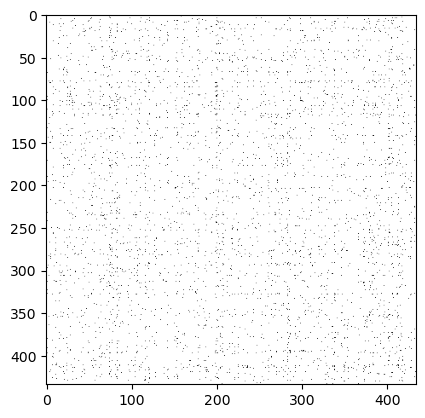

In [121]:
plt.imshow(A,cmap='Greys')
plt.show()

In [6]:
help(client.materialize.synapse_query)

Help on method synapse_query in module caveclient.materializationengine:

synapse_query(pre_ids: Union[int, Iterable, numpy.ndarray] = None, post_ids: Union[int, Iterable, numpy.ndarray] = None, bounding_box=None, bounding_box_column: str = 'post_pt_position', timestamp: datetime.datetime = None, remove_autapses: bool = True, include_zeros: bool = True, limit: int = None, offset: int = None, split_positions: bool = False, desired_resolution: Iterable[float] = None, materialization_version: int = None, synapse_table: str = None, datastack_name: str = None, metadata: bool = True) method of caveclient.materializationengine.MaterializatonClientV3 instance
    Convience method for quering synapses. Will use the synapse table specified in the info service by default.
    It will also remove autapses by default. NOTE: This is not designed to allow querying of the entire synapse table.
    A query with no filters will return only a limited number of rows (configured by the server) and will do 

In [7]:
# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

In [12]:
# lets find all cell that have clean or extended axons
prf_df=client.materialize.query_table('proofreading_status_public_release',
                                      filter_in_dict={'status_axon': ['extended', 'clean']})

In [16]:
all_syn_dfm3.shape, coreg_df.shape, prf_df.shape

((22855, 25), (13925, 19), (1051, 10))

In [20]:
# merge these two to get the set of proofread AND coregistered cells
clean_coreg_df = pd.merge(prf_df, coreg_df, on='pt_root_id')
clean_coreg_df.shape

(676, 28)

In [19]:
clean_coreg_df.columns

Index(['id_x', 'created_x', 'superceded_id', 'valid_x', 'valid_id',
       'status_dendrite', 'status_axon', 'pt_supervoxel_id_x', 'pt_root_id',
       'pt_position_x', 'id_ref', 'created_ref', 'valid_ref', 'volume',
       'pt_supervoxel_id_y', 'id_y', 'created_y', 'valid_y', 'target_id',
       'session', 'scan_idx', 'unit_id', 'field', 'residual', 'score',
       'pt_position_y', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [21]:
np.unique(clean_coreg_df[['id_x']])

array([   1,    7,   10,   11,   14,   16,   18,   19,   20,   21,   22,
         27,   28,   35,   45,   46,   47,   48,   51,   53,   55,   56,
         57,   58,   59,   63,   77,   80,   83,   87,   88,   91,   94,
         95,   97,  100,  105,  109,  110,  114,  115,  119,  120,  123,
        132,  134,  143,  144,  145,  146,  149,  150,  151,  153,  155,
        156,  157,  158,  159,  161,  162,  164,  170,  172,  175,  177,
        178,  181,  182,  187,  191,  193,  194,  195,  198,  205,  206,
        208,  214,  215,  219,  220,  221,  223,  227,  231,  232,  236,
        237,  238,  239,  240,  245,  252,  253,  258,  259,  261,  263,
        265,  266,  269,  271,  272,  274,  280,  281,  283,  287,  289,
        292,  294,  295,  297,  301,  302,  310,  312,  319,  320,  322,
        323,  324,  330,  331,  333,  335,  337,  340,  341,  346,  348,
        351,  352,  353,  357,  358,  360,  362,  364,  367,  371,  372,
        373,  378,  379,  380,  381,  382,  384,  3

In [10]:
all_syn_dfm3.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id', 'pre_pt_position', 'post_pt_position', 'index_pre',
       'scan_session_pre', 'scan_idx_pre', 'field_pre', 'unit_id_pre',
       'score_pre', 'residual_pre', 'index_post', 'scan_session_post',
       'scan_idx_post', 'field_post', 'unit_id_post', 'score_post',
       'residual_post', 'C', 'cell_type_pre', 'cell_type_post'],
      dtype='object')

In [11]:
coreg_df.columns

Index(['id_ref', 'created_ref', 'valid_ref', 'volume', 'pt_supervoxel_id',
       'pt_root_id', 'id', 'created', 'valid', 'target_id', 'session',
       'scan_idx', 'unit_id', 'field', 'residual', 'score', 'pt_position',
       'bb_start_position', 'bb_end_position'],
      dtype='object')

In [14]:
prf_df.columns

Index(['id', 'created', 'superceded_id', 'valid', 'valid_id',
       'status_dendrite', 'status_axon', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position'],
      dtype='object')

In [ ]:
big_df = all_syn_dfm3.merge(coreg_df, how='inner',)

In [15]:
# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)